In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Concatenate, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from helper_funcs import gen_samples
from scipy.fft import rfftfreq
import pickle
import matplotlib.pyplot as plt

2024-12-08 21:35:22.964341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 21:35:23.084789: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 21:35:23.090534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-08 21:35:23.090550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# First navigate to our directory
transfer_directory_path = os.path.join("Data", "synth_transfer_df.parquet")
general_directory_path = os.path.join("Data", "synth_general_df.parquet")
# Load the dataframes
synth_transfer_df = pd.read_parquet(transfer_directory_path)
synth_general_df = pd.read_parquet(general_directory_path)
# Concatenate (after making sure they share columns) and then reset indices
assert list(synth_transfer_df.columns) == list(synth_general_df.columns), "Column names do not match!"
df = pd.concat([synth_transfer_df, synth_general_df], axis=0)
df.reset_index(drop=True, inplace=True)

In [3]:
# Split into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['species'],  # Stratify based on the 'species' column
    random_state=42
)

# Split temp into test (15%) and validation (15%)
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['species'],  # Stratify again to maintain balance
    random_state=42
)

In [4]:
# Prepare samples
print("Generating Training Samples")
X_train, y_train, mins_maxes_train, isolated_peaks_train = gen_samples(train_df)
print("Generating Test Samples")
X_test, y_test, mins_maxes_test, isolated_peaks_test = gen_samples(test_df)
print("Generating Validation Samples")
X_val, y_val, mins_maxes_val, isolated_peaks_val = gen_samples(val_df)

Generating Training Samples
Generating Test Samples
Generating Validation Samples


In [72]:
def weight_func(snr, k=3):
    return ((snr/k)**k) / (1 + (snr/k)**k)


def custom_loss(y_true, y_pred):
    """
    Custom loss function for (batch_size, N, 3):
    - Binary cross-entropy for the first output node.
    - MSE for the second and third output nodes, masked by the first node's true labels.
    - Each bin in each sample is weighted by f(SNR), where SNR is the 3rd node label.
    
    Args:
    y_true: Tensor of true labels, shape (batch_size, N, 3).
    y_pred: Tensor of predicted values, shape (batch_size, N, 3).
    
    Returns:
    A scalar tensor representing the combined loss.
    """

    # Mean squared error for the second and third nodes
    mse_loss_2 = tf.square(y_true[..., 1] - y_pred[..., 1])
    mse_loss_3 = tf.square(y_true[..., 2] - y_pred[..., 2])
    mse_loss = mse_loss_2 + mse_loss_3  # Shape (batch_size, N)

    # Mask the MSE loss where the first node's true label is 0
    mask = tf.cast(y_true[..., 0] > 0, tf.float32)  # Shape (batch_size, N)
    masked_mse_loss = mse_loss * mask  # Shape (batch_size, N)
    
    # Manually calculate binary cross-entropy for the first node
    epsilon = 1e-7  # Small constant to prevent log(0)
    y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # Weighting each bin by weight_func(SNR), where SNR is the 3rd node label
    snr = y_true[..., 2]  # SNR is the 3rd node label, shape (batch_size, N)
    weights = tf.where(snr < 0, tf.ones_like(snr), weight_func(snr))  # If SNR < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func

    # Apply weights to the masked MSE loss
    weighted_mse_loss = masked_mse_loss * weights  # Shape (batch_size, N)
    
    # Apply weights to the BCE loss
    weighted_bce_loss = bce_loss * weights  # Shape (batch_size, N)

    # Average weighted MSE, BCE losses across bins (N) for each sample
    mean_mse_loss_per_sample = tf.reduce_mean(weighted_mse_loss, axis=1)  # Mean over N for shape (batch_size,)
    mean_bce_loss_per_sample = tf.reduce_mean(weighted_bce_loss, axis=1)

    # Combine and average across the batch
    total_loss = tf.reduce_mean(mean_bce_loss_per_sample + mean_mse_loss_per_sample)  # Mean over batch size

    return total_loss

import tensorflow as tf

def peak_counting_error(isolated_labels, predictions):
    """
    Computes the best threshold to minimize peak counting error.

    Args:
    - isolated_labels: Tensor of shape (M, N), where `1` indicates a true peak.
    - predictions: Tensor of shape (M, N), with predicted scores for each bin.

    Returns:
    - best_error: The minimum peak counting error across all thresholds.
    """
    M = tf.shape(isolated_labels)[0]  # Number of samples
    tf.debugging.assert_equal(
        M, tf.shape(predictions)[0],
        message="Mismatch in number of samples between isolated_labels and predictions!"
    )

    best_error = tf.Variable(float('inf'), dtype=tf.float32)
    best_thresh = tf.Variable(0.0, dtype=tf.float32)

    # Iterate through multiple thresholds
    for thresh in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
        current_error = tf.Variable(0.0, dtype=tf.float32)  # Initialize current_error as a tf.Variable
        predictions_snapped = tf.cast(predictions > thresh, tf.int32)

        # Process each row (sample)
        for row in tf.range(M):  # Use tf.range for TensorFlow-compatible iteration
            predictions_row = predictions_snapped[row, :]
            isolated_labels_row = isolated_labels[row, :]

            # Initialize chunk tracking
            current_chunk_value = predictions_row[0]
            current_chunk_start = 0

            # Process each index
            for idx in tf.range(1, tf.shape(predictions_row)[0] + 1):  # +1 to handle the last chunk
                is_last_chunk = idx == tf.shape(predictions_row)[0]
                is_new_chunk = not is_last_chunk and predictions_row[idx] != current_chunk_value

                if is_last_chunk or is_new_chunk:
                    # Process the current chunk
                    chunk_end = idx
                    chunk_labels = isolated_labels_row[current_chunk_start:chunk_end]

                    # Count predicted peaks and actual peaks in the chunk
                    predicted_peaks = tf.cast(current_chunk_value, tf.float32)
                    print(chunk_labels)
                    actual_peaks = tf.reduce_sum(chunk_labels)
                    # Ensure actual_peaks is scalar
                    actual_peaks = tf.squeeze(actual_peaks)

                    # Add squared error to total error
                    current_error.assign_add((predicted_peaks - actual_peaks) ** 2)

                    # Start a new chunk
                    if not is_last_chunk:
                        current_chunk_value = predictions_row[idx]
                    current_chunk_start = idx

        # Average the error across all samples
        current_error.assign(current_error / tf.cast(M, tf.float32))

        # Update the best error and threshold
        if current_error < best_error:
            best_error.assign(current_error)
            best_thresh.assign(thresh)

    tf.print(f"Best threshold: {best_thresh}, Best Peak Counting Error: {best_error}")
    return best_error



        


class ValidationMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, metric_name="peak_counting_error"):
        super().__init__()
        self.validation_data = validation_data
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        val_x, (val_y, val_isolated_labels) = self.validation_data  # Unpack extra labels
        val_predictions = self.model.predict(val_x, verbose=0)
        
        # Compute your custom metric (e.g., Mean Absolute Error)
        val_metric = peak_counting_error(val_isolated_labels, val_predictions)

        # Add the validation metric to logs
        logs[self.metric_name] = val_metric.numpy()

        print(f"Epoch {epoch + 1}: {self.metric_name} = {val_metric.numpy()}")


    


In [70]:
# Define name for this model
model_version = "PP_V1"

# Define the input length / number of frequency bins (N)
N = 8192

# Input layer
input_layer = Input(shape=(N, 1), name="Input")

# Inception-like layer with 1D convolutions
convs = []
# We'll base our kernel choices on the hwhm distribution of the peaks. 
# Thin peaks are in 3Hz-10Hz range --> 5-15 bins
# Wide peaks are in 10Hz-100Hz range --> 15-149 bins
# We choose filters at a range of scales, odd (to facilitate being cenetered around a peak)
# and we want more filters for the medium-small range since there are more peaks at this scale.
# Otherwise largely arbitrarily.
kernels = [(3, 4), (5, 8), (9, 16), (15, 32), (31, 32), (55, 32), (71, 16), (101, 8), (149, 4), (201, 2)]
for kernel_size, num_filters in kernels:
    convs.append(Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same', name=f"Conv_{kernel_size}")(input_layer))

# Concatenate the outputs of all convolutional layers
concat_layer = Concatenate(name="Inception_Concat")(convs)

# Time Distributed Dense Layers
td_dense64 = TimeDistributed(Dense(64, activation='relu'), name="Dense_64")(concat_layer)
td_dense32A = TimeDistributed(Dense(32, activation='relu'), name="Dense_32A")(td_dense64)
# bd_LSTM = Bidirectional(LSTM(16, return_sequences=True), name="LSTM")(td_dense32A)
# td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(bd_LSTM)
td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(td_dense32A)
td_dense16 = TimeDistributed(Dense(16, activation='relu'), name="Dense_16")(td_dense32B)

# Final layer with 3 outputs per input bin
output = TimeDistributed(Dense(3, activation=None), name="Output")(td_dense16)

# Define the model
model = Model(inputs=input_layer, outputs=output, name=model_version)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss, metrics=[peak_counting_error])

# Summary
# model.summary()


In [71]:
# Define batch size, number of epochs, and patience
batch_size = 32
epochs = 15
patience = 3

weight_path = os.path.join("PP Weights", f"{model_version}.keras")



# Add callbacks for better training
callbacks = [
    ValidationMetricCallback(validation_data=(X_val, (y_val, isolated_peaks_val)), metric_name="peak_counting_error"),
    EarlyStopping(monitor="peak_counting_error", patience=patience, restore_best_weights=True, verbose=1),  # Stop if no improvement for 5 epochs
    ModelCheckpoint(weight_path, save_best_only=True, monitor='val_loss')  # Save the best model
]



# Train the model
history = model.fit(
    X_train,                # Training data
    y_train,                # Training labels
    validation_data=(X_val, y_val),  # Validation data
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)

with open(f'{model_version}_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/15


ValueError: in user code:

    File "/tmp/ipykernel_317/3159667805.py", line 94, in peak_counting_error  *
        if is_last_chunk or is_new_chunk:

    ValueError: condition of if statement expected to be `tf.bool` scalar, got [False False False]; to check for None, use `is not None`


In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)  # Verbose output for evaluation

print("Test Loss:", test_loss)

In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
# Verify Custom Loss
# Example data: batch_size=4, N=5, nodes=3
y_true = np.array([
    [[0, 0.5, 0.7], [0, 0.2, -1], [0, 10000, -1000], [0, 0.3, 10], [0, 0.1, 10]],  # Sample 1
    [[0, 0.6, 0.3], [1, 0.1, -1], [1, 0.3, 10], [0, 0.4, 10], [0, 0.7, 10]],  # Sample 2
    [[0, 0.4, 1.5], [1, 0.8, -1], [1, 0.6, 10], [1, 0.2, 10], [0, 0.9, 10]],  # Sample 3
    [[0, 0.5, 0.6], [0, 0.3, -1], [0, 0.7, 10], [1, 0.1, 10], [0, 0.8, 10]],  # Sample 4
])

y_pred = np.array([
    [[0.9, 0.6, 0.8], [0.9, 0.3, 0.5], [0.5, 100000, 1000], [0.7, 0.4, 0.6], [0.2, 0.1, 0.3]],  # Sample 1
    [[0.7, 0.5, 0.4], [0.9, 0.2, 0.3], [0.9, 0.4, 0.6], [0.6, 0.7, 0.9], [0.8, 0.7, 0.8]],  # Sample 2
    [[0.8, 0.4, 0.5], [0.9, 0.6, 0.8], [0.9, 0.7, 0.5], [0.9, 0.3, 0.6], [0.2, 0.9, 0.7]],  # Sample 3
    [[0.9, 0.4, 0.3], [0.9, 0.6, 0.8], [0.6, 0.9, 0.7], [0.9, 0.3, 0.5], [0.8, 0.7, 0.6]],  # Sample 4
])

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

loss_value = custom_loss(y_true_tensor, y_pred_tensor)
print("Loss Value:", loss_value.numpy())

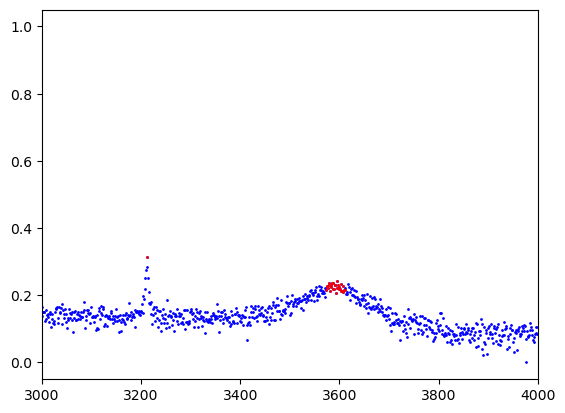

In [56]:
# Plot a sample
i = 1
spectrum = X_train[i]
f = rfftfreq(32768, 1/44100)[0:8192]

labels = y_train[i, :, :]
spread_peak_labels = labels[:, 0]
indices = np.where(spread_peak_labels == 1)[0]
# isolated_peaks = isolated_peaks_train[i]
# indices = np.where(isolated_peaks == 1)[0]
plt.scatter(f, spectrum, color='blue', s=1)
plt.scatter(f[indices], spectrum[indices], color='red', s=1)
plt.xlim(3000, 4000)
plt.show()

In [ ]:
# Verify peak_counting_error
val_isolated_labels=np.array(
    [[0, 1, 0, 0, 1], 
     [1, 0, 1, 0, 0]]
    )
val_predictions=np.array(
    [[0.81, 0.91, 0.71, 0.31, 0.91],
     [0.81, 0.21, 0.91, 0.96, 0.91]]
    )

peak_counting_error(val_isolated_labels, val_predictions)

In [ ]:
# Figure out how many bins our peaks are
f = rfftfreq(32768, 1/44100)
# HWFM (in bins) of a peak with a HWHM of 100Hz
bin_width = f[1] - f[0]
print(f"HWFM (in bins) of a peak with a HWHM of 100Hz: {200 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 10Hz: {20 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 3Hz: {6 / bin_width}")